## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import tweepy
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime

In [2]:
# Turn on retina mode for high-quality inline plot resolution
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [3]:
# Version of Python
import platform
platform.python_version()

'2.7.13'

In [4]:
# Import Twitter API keys
from credentials import *

In [5]:
# Helper function to connect to Twitter API
def twitter_setup():
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
    
    api = tweepy.API(auth)
    return api

In [6]:
# Extract Twitter data
extractor = twitter_setup()

# Twitter user
twitter_handle = 'realdonaldtrump'

# Get most recent two hundred tweets
tweets = extractor.user_timeline(screen_name=twitter_handle, count=200)
print('Number of tweets extracted: {}.\n'.format(len(tweets)))

Number of tweets extracted: 200.



## Tweet activity

Let's explore counts by hour, day of the week, and weekday versus weekend hourly trends.

In [7]:
# Inspect attributes of tweepy object
print(dir(tweets[0])) # look at the first element/record

['__class__', '__delattr__', '__dict__', '__doc__', '__eq__', '__format__', '__getattribute__', '__getstate__', '__hash__', '__init__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_api', '_json', 'author', 'contributors', 'coordinates', 'created_at', 'destroy', 'entities', 'extended_entities', 'favorite', 'favorite_count', 'favorited', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'parse', 'parse_list', 'place', 'possibly_sensitive', 'retweet', 'retweet_count', 'retweeted', 'retweeted_status', 'retweets', 'source', 'source_url', 'text', 'truncated', 'user']


Hmmm, what's this **`created_at`** attribute?

In [8]:
# What format is it in? answer: GMT, according to Twitter API
print(tweets[0].created_at)

2017-10-10 13:34:58


In [9]:
# Create datetime index: convert to GMT then to Eastern daylight time EDT
tweet_dates = pd.DatetimeIndex([tweet.created_at for tweet in tweets], tz='GMT').tz_convert('US/Eastern')

### Hourly counts:

In [10]:
# Count the number of tweets per hour
num_per_hour = pd.DataFrame( { 'counts': Counter(tweet_dates.hour) })

In [11]:
# Create hours data frame
hours = pd.DataFrame({'hours': np.arange(24)})

Because there are hours of the day where there are no tweets, one must explicitly add any zero-count hours to the index.

In [12]:
# Merge data frame objects on common index, peform left outer join and fill NaN with zero-values
hour_counts = pd.merge(hours, num_per_hour, left_index=True, right_index=True, how='left').fillna(0)

### Day of the week counts:

In [13]:
# Count the number of tweets by day of the week
num_per_day = pd.DataFrame( { 'counts': Counter(tweet_dates.weekday) })

In [14]:
# Create days data frame
days = pd.DataFrame({'day': np.arange(7)})

In [15]:
# Merge data frame objects on common index, perform left outer join and fill NaN with zero-values
daily_counts = pd.merge(days, num_per_day, left_index=True, right_index=True, how='left').fillna(0)

### Weekday vs weekend hourly counts:

In [16]:
# Flag the weekend from weekday tweets
weekend = np.where(tweet_dates.weekday < 5, 'weekday', 'weekend')

In [17]:
# Construct multiply-indexed DataFrame obj indexed by weekday/weekend and by hour
by_time = pd.DataFrame([tweet.created_at for tweet in tweets], 
                       columns=['counts'],
                       index=tweet_dates).groupby([weekend, tweet_dates.hour]).count() 

In [18]:
# Optionally, set the names attribute of the index
by_time.index.names=['daytype', 'hour']

In [19]:
# Show two-dimensional view of multiply-indexed DataFrame
by_time.unstack()

counts                                                                 \
hour        6     7     8    9    10   11   12   13   14    15   16   17   18   
daytype                                                                         
weekday   23.0  19.0   3.0  8.0  2.0  2.0  2.0  2.0  1.0   2.0  3.0  4.0  9.0   
weekend    4.0  16.0  10.0  3.0  5.0  NaN  NaN  NaN  6.0  16.0  3.0  3.0  7.0   

                                    
hour      19    20    21   22   23  
daytype                             
weekday  9.0  12.0  14.0  5.0  NaN  
weekend  4.0   NaN   1.0  1.0  1.0

In [20]:
# Merge DataFrame on common index, perform left outer join and fill NaN with zero-values
by_time = pd.merge(hours, by_time.unstack(level=0), left_index=True, right_index=True, how='left').fillna(0)

/home/ellkle/anaconda2/lib/python2.7/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [21]:
# Show last five records
by_time.tail()

,hours,"(counts, weekday)","(counts, weekend)"
19,19,9.0,4.0
20,20,12.0,0.0
21,21,14.0,1.0
22,22,5.0,1.0
23,23,0.0,1.0


## Visualize tweet counts

### By hour:

In [22]:
# Optional: Create xtick labels in Standard am/pm time format
xticks = pd.date_range('00:00', '23:00', freq='H', tz='US/Eastern').map(lambda x: pd.datetime.strftime(x, '%I %p'))

Let's see if we can "fancy-it-up" a bit by making it 538 blog-like. Note: The following cell disables notebook autoscrolling for long outputs. Otherwise, the notebook will embed the plot inside a scrollable cell, which is more difficult to read the plot.

In [23]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

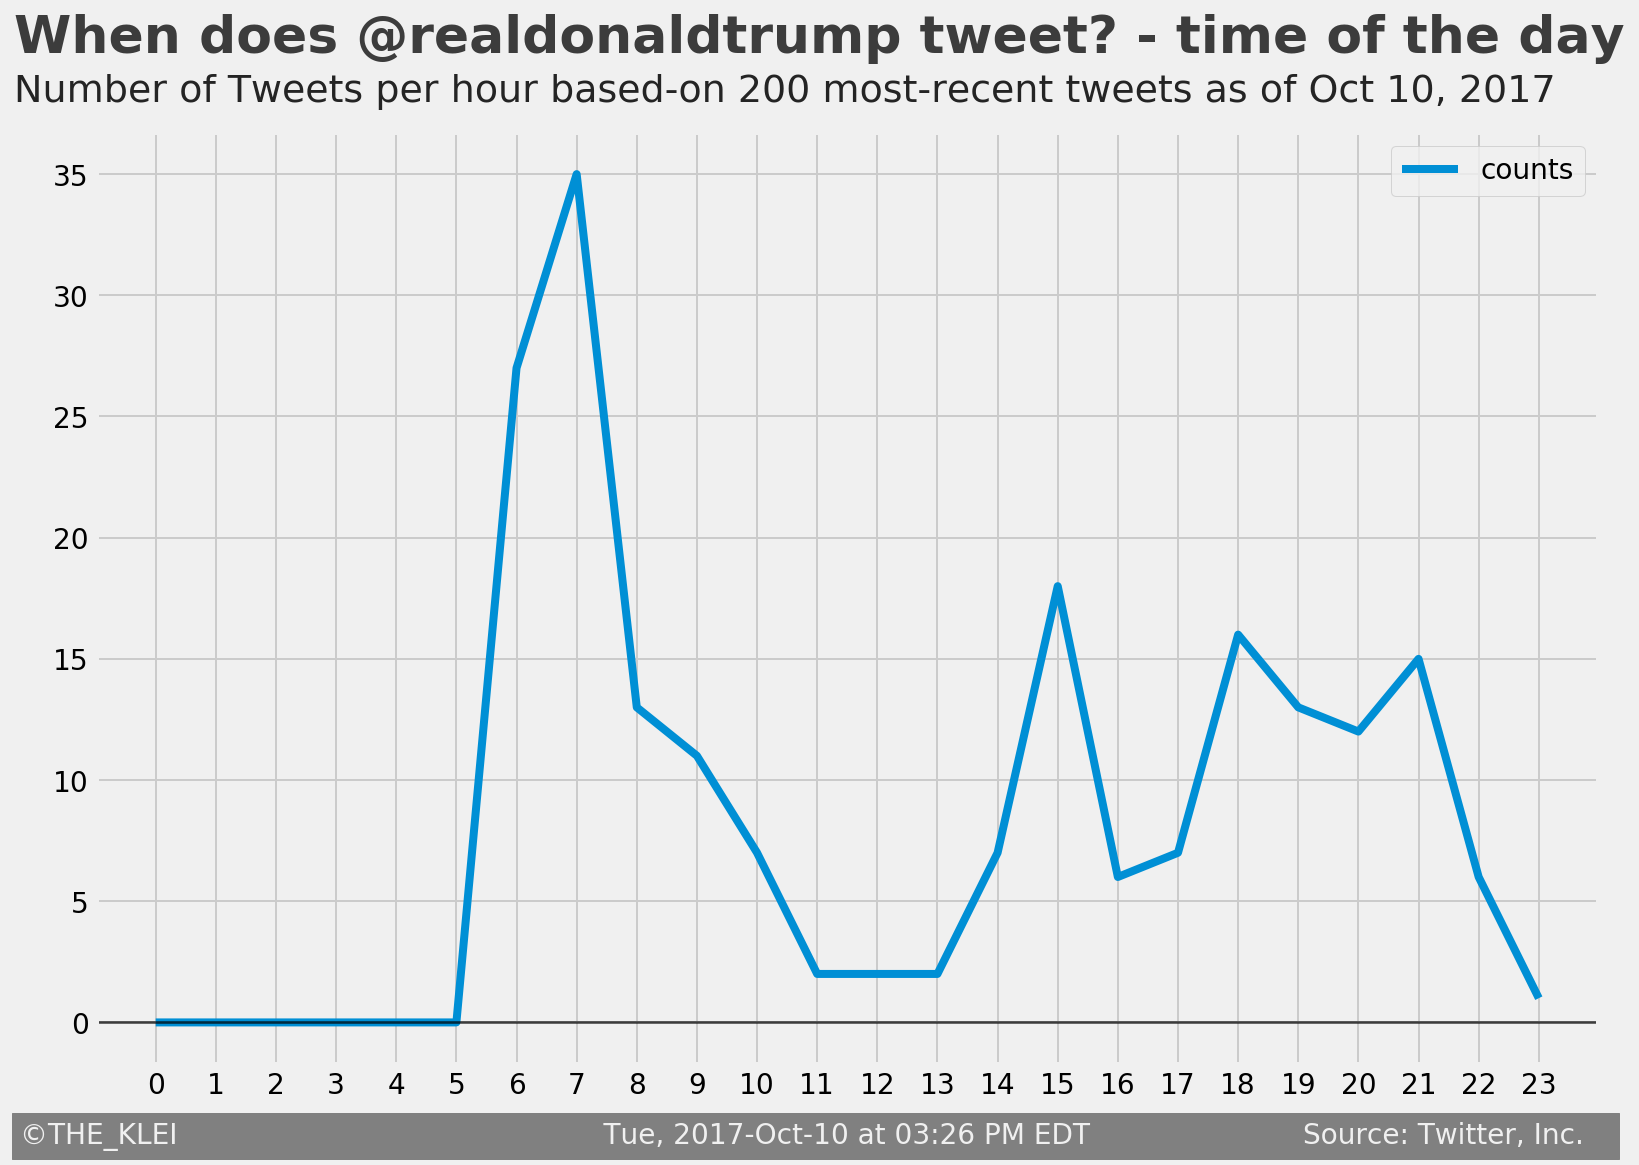

In [28]:
# Plot
ax = hour_counts.plot(x='hours', y='counts', kind='line', figsize=(12, 8))
ax.set_xticks(np.arange(24))

#ax.set_xticklabels(xticks, rotation=50)
#ax.set_title('Number of Tweets per hour')
#ax.set_xlabel('Hour')
#ax.set_ylabel('No. of Tweets')

#ax.set_yticklabels(labels=['0  ', '5  ', '10  ', '15  ', '20  ', '25  ', '30  ', '35  ', '40  '])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.7)
ax.set_xlim(left=-1, right=24)
ax.xaxis.label.set_visible(False)

now = datetime.strftime(datetime.now(), '%a, %Y-%b-%d at %I:%M %p EDT')
ax.text(x=-2.25, y=-5.,
    s = u"\u00A9" + 'THE_KLEI                                                {}                        Source: Twitter, Inc.   '.format(now),
    fontsize=14, color='#f0f0f0', backgroundcolor='grey')

ax.text(x=-2.35, y=40, s="When does @{} tweet? - time of the day".format(twitter_handle),
               fontsize=26, weight='bold', alpha=0.75)

ax.text(x=-2.35, y=38, 
               s='Number of Tweets per hour based-on 200 most-recent tweets as of {}'.format(datetime.strftime(datetime.now(), '%b %d, %Y')),
              fontsize=19, alpha=0.85)

plt.show()

### By day:

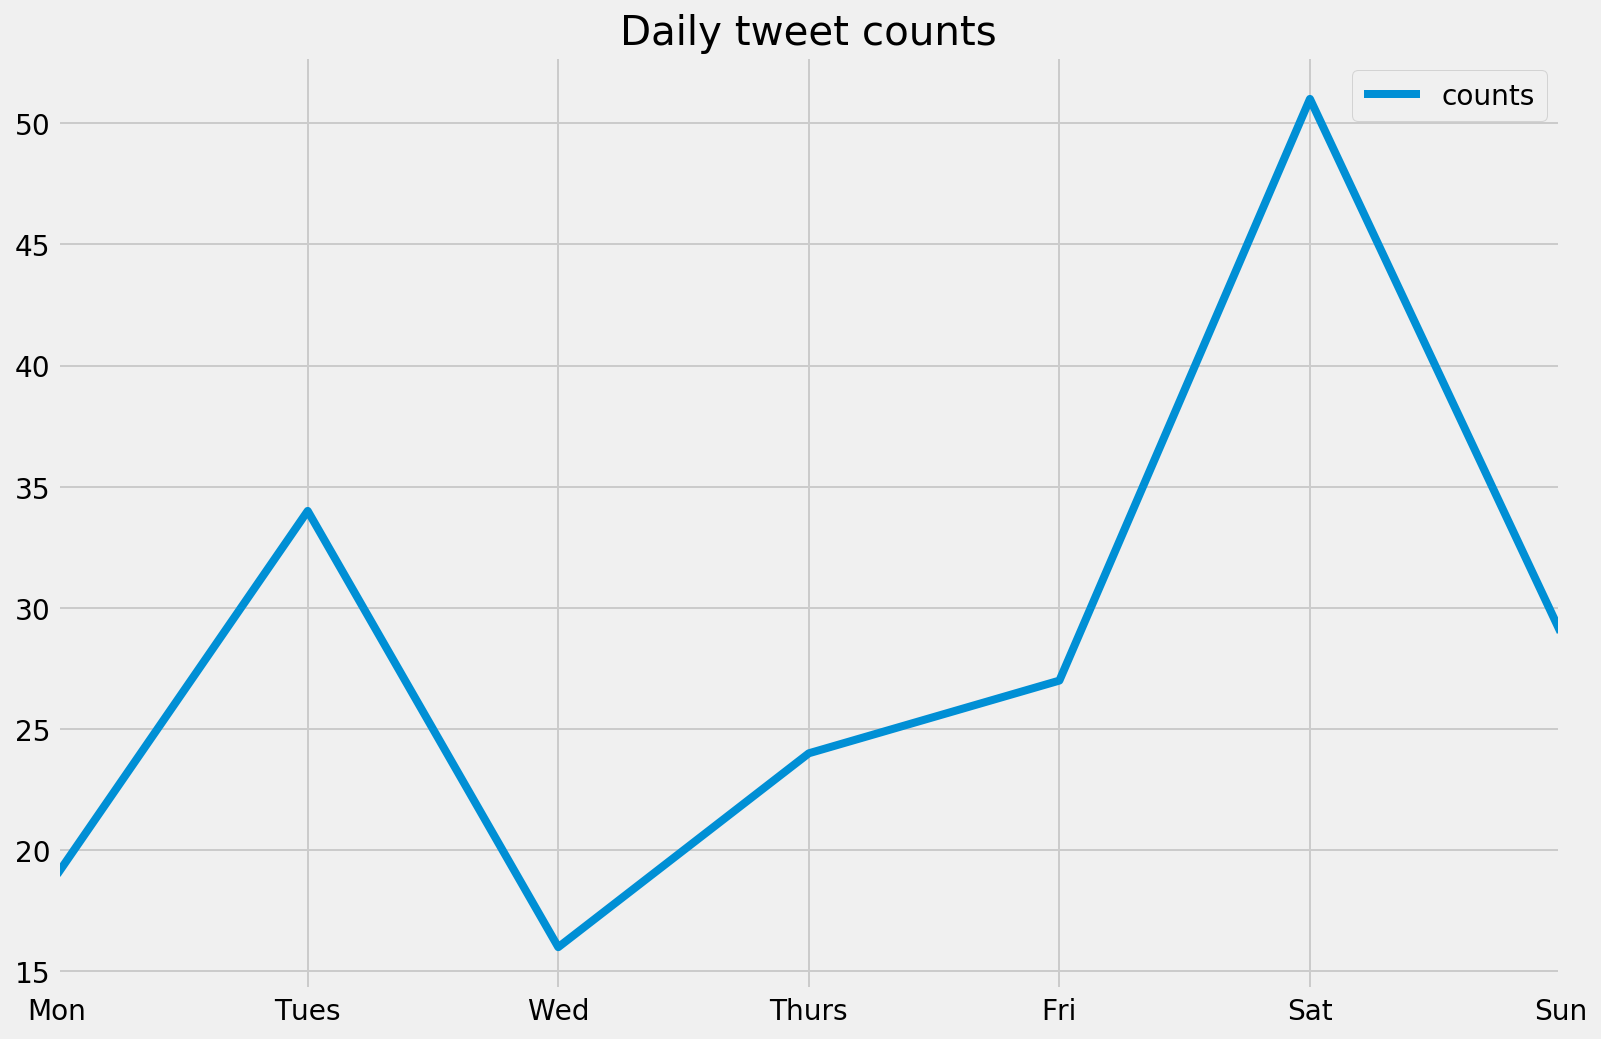

In [25]:
# Plot
daily_counts.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
daily_counts['counts'].plot(title='Daily tweet counts', figsize=(12, 8), legend=True)
plt.show()

### By weekday and weekend:

In [26]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

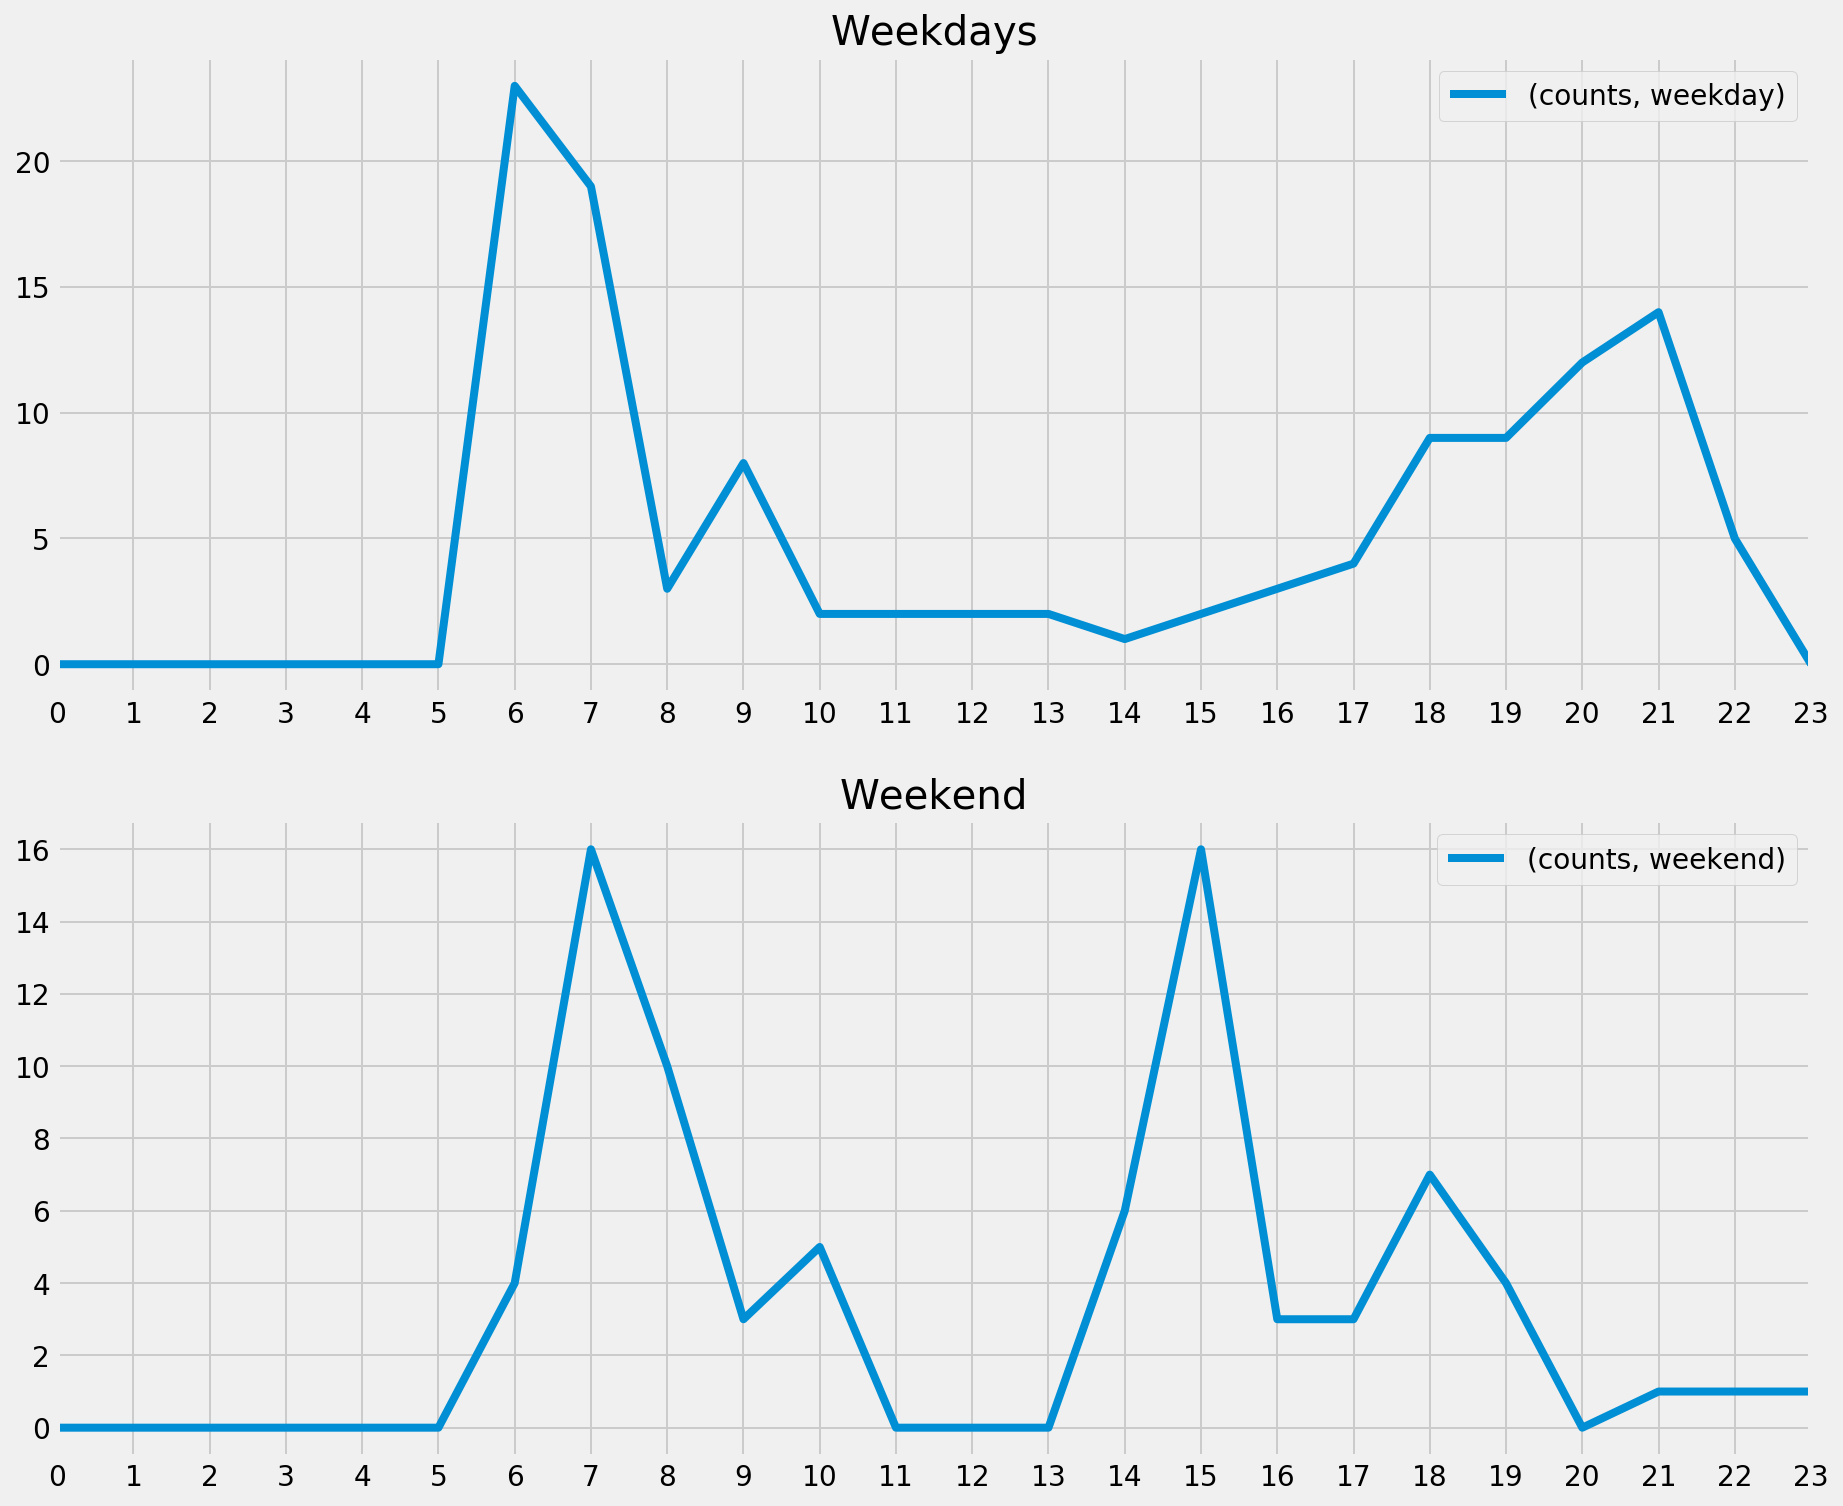

In [27]:
# Plot
fig, ax = plt.subplots(2, 1, figsize=(14, 12))
# weekdays
by_time.loc[:, [('counts', 'weekday')]].plot(ax=ax[0], title='Weekdays', kind='line')
# weekends
by_time.loc[:, [('counts', 'weekend')]].plot(ax=ax[1], title='Weekend', kind='line')

ax[0].set_xticks(np.arange(24))
#ax[0].set_xticklabels(xticks, rotation=50)

ax[1].set_xticks(np.arange(24))
#ax[1].set_xticklabels(xticks, rotation=50)

plt.show()